In [1]:
import os
import copy
import torch
import open_clip
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import pickle as pkl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from datasets import CUBDataset, get_transforms, DEFAULT_ATTR_INDICES

%load_ext autoreload
%autoreload 2

# Dataset

Check `CUBDataset` and attributes

In [3]:
dataset = CUBDataset(os.path.join('datasets', 'CUB'), split='train', use_class_level_attr=False, transforms=None)

img_id: tensor(7500) class_id: tensor(127)
attribute labels:
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])


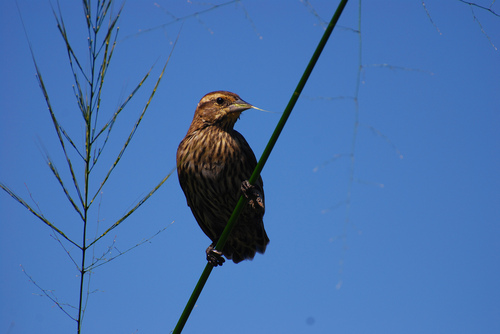

In [4]:
img_id, img, class_id, attrs = dataset[31]
print('img_id:', img_id, 'class_id:', class_id)
print('attribute labels:')
print(attrs)
img

In [5]:
dataset.get_instance_attr_names(img_id, attrs)

,attr_name
10,has_wing_color::brown
25,has_upperparts_color::brown
40,has_underparts_color::brown
59,has_back_color::brown
80,has_upper_tail_color::brown
99,has_head_pattern::eyebrow
106,has_breast_color::brown
145,has_eye_color::black
153,has_forehead_color::brown
168,has_under_tail_color::brown


Load `CUBDataset` to `dataloader` and check

In [8]:
transforms = get_transforms()
dataset = CUBDataset(os.path.join('datasets', 'CUB'),
                     split='train',
                     use_class_level_attr=False,
                     transforms=transforms)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
dataloader_iter = iter(dataloader)

In [10]:
img_id, img, class_id, attrs = next(dataloader_iter)

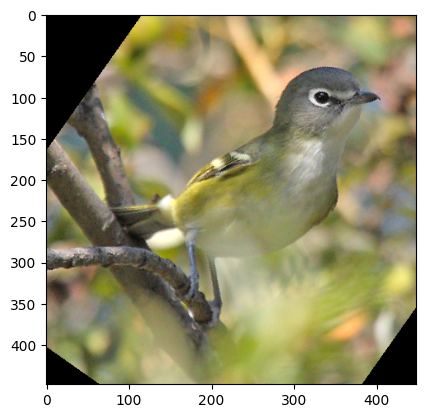

In [14]:
plt.imshow(img.squeeze().permute(1, 2, 0).numpy())
plt.show()

In [15]:
transforms = get_transforms()
dataset = CUBDataset(os.path.join('datasets', 'CUB'),
                     split='train',
                     use_class_level_attr=False,
                     transforms=transforms)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataloader_iter = iter(dataloader)

In [20]:
next(dataloader_iter)

[tensor([ 1379,  6127,  1165,  1990,  9079,  8960,   689,  4433,   426, 11432,
          3001,  9502,  2427,  9431,  4320, 10143]),
 tensor([[[[0.7569, 0.7647, 0.7725,  ..., 0.7608, 0.7529, 0.7529],
           [0.7255, 0.7333, 0.7412,  ..., 0.7647, 0.7569, 0.7529],
           [0.6745, 0.6863, 0.7020,  ..., 0.7608, 0.7569, 0.7569],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.8745, 0.8784, 0.8902,  ..., 0.8902, 0.8824, 0.8824],
           [0.8510, 0.8549, 0.8627,  ..., 0.8902, 0.8902, 0.8824],
           [0.8078, 0.8157, 0.8275,  ..., 0.8941, 0.8902, 0.8902],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.9569, 0.9608